In [1]:
import gzip
import operator as op
import typing as t
from collections import Counter
from itertools import chain, groupby, takewhile
from concurrent.futures import ThreadPoolExecutor

import regex as re
import numpy as np
import seaborn as sns
import tqdm
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.Alphabet import generic_dna
from Bio.SeqRecord import SeqRecord
from fn import F, iters

sns.set(color_codes=True)

%matplotlib inline

Region extraction utilities

In [49]:
ALPHABET = {
    'A': 'A',
    'C': 'C',
    'G': 'G',
    'T': 'T',
    'R': '[AG]',
    'Y': '[CT]',
    'S': '[GC]',
    'W': '[AT]',
    'K': '[GT]',
    'M': '[AC]',
    'B': '[CGT]',
    'D': '[AGT]',
    'H': '[ACT]',
    'V': '[ACG]',
    'N': '[ACGT]'
}

Primer = t.Callable[[str], t.Optional[t.Tuple[int, int]]]


def mkprimer(substitutions: int, primer_sequence: str) -> Primer:
    """
    Create a universal primer.
    :param substitutions: the number of allowed mismatches
    :param primer: An IUPAC-encoded primer sequence
    :return: A callable that searches for the first occurrence of the primer
             in a sequence and returns it's span (if found).
    :raises ValueError: primer sequence contains non-IUPAC DNA characters.  
    """
    try:
        base = ''.join(ALPHABET[base] for base in primer_sequence)
        fuzzy = f'{{s<={substitutions}}}' if substitutions else ''
        pattern = re.compile(f'(:?{base}){fuzzy}', flags=re.BESTMATCH)
    except KeyError as err:
        raise ValueError(f'unknown base: {err}')
    
    def primer(sequence: str) -> Optional[Tuple[int, int]]:
        match = pattern.search(sequence)
        return match.span() if match else None
    
    return primer


def extract_region(forward: Primer, reverse: Primer, seqrec: SeqRecord) -> t.Optional[SeqRecord]:
    """
    Extract a region flanked by the primers 
    """
    try:
        _, start = forward(str(seqrec.seq))
        end, _ = reverse(str(seqrec.seq))
    except TypeError: # can't find primers
        return None
    return seqrec[start:end]


fwd_primer = mkprimer(2, 'CCTACGGGNGGCWGCAG')
rev_primer = mkprimer(2, str(Seq('GACTACHVGGGTATCTAATCC', generic_dna).reverse_complement()))

Read sequences, discard short records, extract the amplified region, discard failed records

In [50]:
def back_transcribe(seqrec: SeqRecord) -> SeqRecord:
    """
    Back-transcribe an RNA sequence record
    """
    return SeqRecord(id=seqrec.id, name=seqrec.name, description=seqrec.description,
                     seq=seqrec.seq.back_transcribe())

def parse_taxonomy(seqrec: SeqRecord) -> t.List[str]:
    """
    Parse taxonomy from SILVA sequence records
    """
    return seqrec.description.split(' ', 1)[1].split(';')


with gzip.open('/mnt/nas/storage/ilia/repsets/silva/v138/SILVA_138_SSURef_tax_silva.fasta.gz', 'rt') as silva_buffer:
    with ThreadPoolExecutor(8) as workers:
        silva_seqs = (
            F(filter, lambda seqrec: 1100 <= len(seqrec) <= 1600) 
            >> (map, back_transcribe)  
            >> (workers.map, F(extract_region, fwd_primer, rev_primer))  
            >> (filter, bool)  
            >> list
        )(SeqIO.parse(silva_buffer, 'fasta'))

Plot sequence length distribution

In [52]:
silva_taxonomy = list(map(parse_taxonomy, silva_seqs))

In [53]:
stopwords = ['uncultured', 'unidentified', 'metagenome']
taxlength = 7

seqs_filt, taxa_filt = zip(*[
    (seq, tax) for seq, tax in zip(silva_seqs, silva_taxonomy)
    if len(tax) == taxlength and not any(word in tax[-1] for word in stopwords)
])

print(f'{len(seqs_filt)} sequences left out of {len(silva_seqs)}')

579402 sequences left out of 1984125


In [54]:
Counter(tax[5] for tax in taxa_filt).most_common(50)

[('Bacillus', 56779),
 ('Pseudomonas', 31127),
 ('Staphylococcus', 26084),
 ('Streptomyces', 21775),
 ('Streptococcus', 21306),
 ('Escherichia-Shigella', 20514),
 ('Lactobacillus', 20444),
 ('Salmonella', 12583),
 ('Vibrio', 11624),
 ('Acinetobacter', 11530),
 ('Enterococcus', 11067),
 ('Mycobacterium', 10799),
 ('Klebsiella', 10117),
 ('Burkholderia-Caballeronia-Paraburkholderia', 8496),
 ('Enterobacter', 7582),
 ('Allorhizobium-Neorhizobium-Pararhizobium-Rhizobium', 6199),
 ('Paenibacillus', 5908),
 ('Aeromonas', 4642),
 ('Serratia', 4324),
 ('Microbacterium', 4172),
 ('Neisseria', 4043),
 ('Pseudoalteromonas', 4021),
 ('Campylobacter', 3779),
 ('Candidatus Phytoplasma', 3776),
 ('Bradyrhizobium', 3755),
 ('Stenotrophomonas', 3540),
 ('Listeria', 3446),
 ('Halomonas', 3411),
 ('Lactococcus', 3375),
 ('Pantoea', 3088),
 ('Flavobacterium', 2933),
 ('Rhodococcus', 2912),
 ('Corynebacterium', 2783),
 ('Micromonospora', 2648),
 ('Leuconostoc', 2643),
 ('Mesorhizobium', 2580),
 ('Clostridi

Rename sequences. Remove duplicates (a duplicate is a sequence with exactly the same taxonomy and sequence).

In [55]:
renamed = [
    SeqRecord(id=';'.join(['Root', *tax]), name='', description='', seq=seqrec.seq)
    for seqrec, tax in zip(seqs_filt, taxa_filt)
]

# group records by taxonomy and sequence

tax_groups = iters.group_by(lambda x: x.id, renamed)
seq_groups = [iters.group_by(lambda x: x.seq, grp) for grp in tax_groups.values()]
unique = list(chain.from_iterable([
    [seq_grp[0] for seq_grp in tax_grp.values()]
    for tax_grp in seq_groups
]))

Remove fragments that deviate too far from the common fragment length

[(350, 450)]

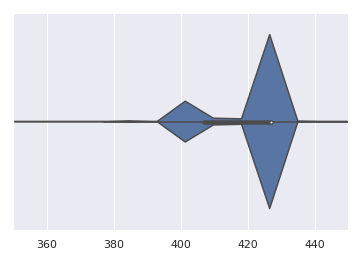

In [8]:
sns.violinplot(
    [len(seqrec) for seqrec in unique]
).set(xlim=(350, 450))

In [13]:
unique_filt = (seqrec for seqrec in unique if 380 <= len(seqrec) <= 440)

In [ ]:
SeqIO.write(unique_filt, 'silva_ref_138_v34.fna', 'fasta')